PERFORM UNSUPERVISED BOUNDARY LAYER CLASSIFICATION
=================
Perform unsupervised boundary layer classification on one of the dataset of Passy-2015 2nd IOP.
Take in input the dataset generated by `prepdataset.py`.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from scipy.cluster import hierarchy as hc

from blcovid import utils
from blcovid import graphics

In [2]:
linkageStategy="average"
metricName="cityblock"

In [5]:
outputDir="../working-directories/2-unidentified-labels/"
saveNetcdf=False

storeImages=False
fmtImages='.png'
figureDir=outputDir

datasetpath="../working-directories/1-unlabelled-datasets/DATASET_2015_0219.PASSY2015_BT-T_linear_dz40_dt30_zmax2000.nc"

Loading and checking dataset
==============================

In [6]:
print("Loading dataset :",datasetpath)
X_raw,t_common,z_common=utils.load_dataset(datasetpath,variables_to_load=['X_raw','time','altitude'])
print("Shape X_raw=",np.shape(X_raw))
print("Percentage of NaN=",100*np.sum(np.isnan(X_raw))/np.size(X_raw),"%")

Loading dataset : ../working-directories/1-unlabelled-datasets/DATASET_2015_0219.PASSY2015_BT-T_linear_dz40_dt30_zmax2000.nc
Shape X_raw= (2112, 2)
Percentage of NaN= 0.0 %


Quicklooks
----------

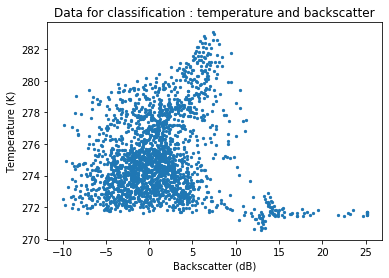

In [7]:
plt.figure()
plt.title("Data for classification : temperature and backscatter")
plt.scatter(X_raw[:,0],X_raw[:,1],s=5)
plt.xlabel("Backscatter (dB)")
plt.ylabel("Temperature (K)")
plt.show(block=False)

Normalization
-------------

In [8]:
scaler=StandardScaler()
scaler.fit(X_raw)
X=scaler.transform(X_raw)

Kmeans clustering
=========================


In [13]:
target_nb_clusters = 4
n_inits=10

In [14]:
from sklearn.cluster import KMeans

km=KMeans(n_clusters=target_nb_clusters,n_init=n_inits)
km.fit(X)
zoneID=km.labels_
zoneID

array([1, 1, 1, ..., 2, 2, 2], dtype=int32)

Hierarchical clustering
=========================


Get hierarchy
---------------

In [9]:
linkageMatrix=hc.linkage(X,method=linkageStategy,metric=metricName)

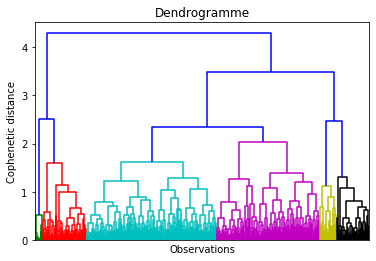

In [10]:
plt.figure()
plt.title(u"Dendrogramme")
hc.dendrogram(linkageMatrix,p=10,truncate_mode='level',distance_sort='ascending',color_threshold=2.25,no_labels=True)
plt.ylabel("Cophenetic distance")
plt.xlabel("Observations")
plt.show(block=False)
if storeImages:
	plt.savefig(figureDir+"dendrogramme"+fmtImages)

Get flat clusters
------------------

In [11]:
target_nb_clusters = 4

In [12]:
zoneID=hc.fcluster(linkageMatrix,t=target_nb_clusters,criterion='maxclust')
zoneID

array([2, 2, 2, ..., 3, 3, 3], dtype=int32)

Vizualisation of clusters
-------------------------

In [15]:
graphics.storeImages = storeImages
graphics.fmtImages = fmtImages
graphics.figureDir = figureDir

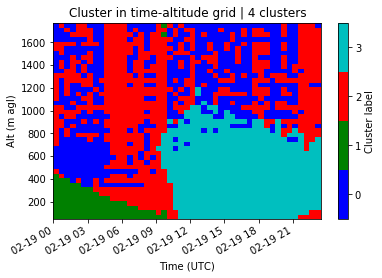

In [16]:
graphics.clusterZTview(t_common,z_common,zoneID)

In [18]:
prepParams = utils.load_preparation_params(datasetpath)
predictors = prepParams[0]

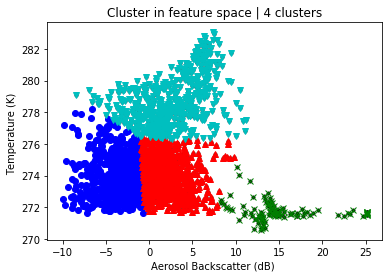

In [19]:
graphics.cluster2Dview(X_raw[:,0],predictors[0],X_raw[:,1],predictors[1],zoneID)

Quality scores
--------------
### Calinski-Harabaz index

In [20]:
ch_score=metrics.calinski_harabasz_score(X,zoneID)
print("Calinski-Harabaz index:",ch_score)

Calinski-Harabaz index: 1831.0715479294481


### Silhouette score

In [21]:
s_score=metrics.silhouette_score(X,zoneID,metric=metricName)
print("Silhouette score:",s_score)

Silhouette score: 0.3798519629186681


### Davies-Bouldin index

In [22]:
db_score=metrics.davies_bouldin_score(X,zoneID)
print("Davies-Bouldin index:",db_score)

Davies-Bouldin index: 0.8100619972847668


Write labels in netCDF
----------------------

In [23]:
datasetname = datasetpath.split('/')[-1]
prefx,prepkey,dotnc = datasetname.split('.')
unidfname="UNIDFLABELS_"+prefx[-9:]+"."+prepkey+".nc"
outputDir+unidfname

'../working-directories/2-unidentified-labels/UNIDFLABELS_2015_0219.PASSY2015_BT-T_linear_dz40_dt30_zmax2000.nc'

In [24]:
if saveNetcdf:
    utils.add_rawlabels_to_netcdf(datasetpath,outputDir+unidfname,zoneID,quiet=False)
else:
    print("No netCDF saved. Set saveNetcdf=True if you want to save it")

No netCDF saved. Set saveNetcdf=True if you want to save it
